# Проект по А/B-тестированию

**Цели исследования:**

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оценим корректность проведения теста.
- Проанализируем результаты теста.

Чтобы оценить корректность проведения теста, проверим:
- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.


**Техническое задание:**

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase.

Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

**Данные:**

- /datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;

Структура файла: 
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.



- /datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.



- /datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.



- /datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

# 1.  Откроем файл с данными и изучим общую информацию

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
import math as mth
from scipy import stats as st

Импортируем данные:

In [2]:
project_marketing_events = pd.read_csv('/Users/olya/Desktop/Портфолио/Выпускной проект/Данные/ab_project_marketing_events.csv')
events = pd.read_csv('/Users/olya/Desktop/Портфолио/Выпускной проект/Данные/final_ab_events.csv')
users = pd.read_csv('/Users/olya/Desktop/Портфолио/Выпускной проект/Данные/final_ab_new_users.csv')
participants = pd.read_csv('/Users/olya/Desktop/Портфолио/Выпускной проект/Данные/final_ab_participants.csv')
tables = [project_marketing_events, events, users, participants]
tables_name = ['project_marketing_events', 'events', 'users', 'participants']

Знакомимся с датафреймами:

In [3]:
for i in range(len(tables)):
  print(tables_name[i])
  display(tables[i].head())
  tables[i].info()
  print()

project_marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB



# 2. Подготовка данных

1) Преобразуем к типу datetime следующие столбцы:
- start_dt и finish_dt таблицы project_marketing_events; 
- event_dt таблицы events; 
- first_date таблицы users.

In [4]:
project_marketing_events['start_dt'] = pd.to_datetime(project_marketing_events['start_dt'])

In [5]:
project_marketing_events['finish_dt'] = pd.to_datetime(project_marketing_events['finish_dt'])

In [6]:
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [7]:
users['first_date'] = pd.to_datetime(users['first_date'])

In [8]:
#проверка
# for i in range(len(tables)):
#   print(tables_name[i])
#   display(tables[i].head())
#   tables[i].info()
#   print()

2) Анализ пропущенных значений и дубликатов

In [9]:
for i in range(len(tables)):
  print(tables_name[i])
  print(tables[i].isna().sum())
  print()

project_marketing_events
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

events
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

users
user_id       0
first_date    0
region        0
device        0
dtype: int64

participants
user_id    0
group      0
ab_test    0
dtype: int64



В таблице events в столбце details имеется большое кол-во пропусков. Возможно они связаны с тем, что не для всех событий нужны дополнительные данные. Пропуски оставляем как есть. Перейдем к поиску дубликатов.

In [10]:
for i in range(len(tables)):
  print(tables_name[i])
  print(tables[i].duplicated().sum())
  print()

project_marketing_events
0

events
2

users
0

participants
0



В таблице events обнаружили два дубликата, удалим их.


In [11]:
events = events.drop_duplicates()
print(events.duplicated().sum())

0


# 3. Оценка корректности проведения теста

Для удобства исследования объединим таблицы events, participants и users.

In [12]:
tables_mix = events.merge(users, on = 'user_id', how = 'outer').merge(participants, on = 'user_id', how = 'outer')
tables_mix.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99,2020-12-07,N.America,iPhone,NaN,NaN
1,E1BDDCE0DAFA2679,2020-12-09,purchase,9.99,2020-12-07,N.America,iPhone,NaN,NaN
2,E1BDDCE0DAFA2679,2020-12-25,purchase,499.99,2020-12-07,N.America,iPhone,NaN,NaN
3,E1BDDCE0DAFA2679,2020-12-07,login,NaN,2020-12-07,N.America,iPhone,NaN,NaN
4,E1BDDCE0DAFA2679,2020-12-09,login,NaN,2020-12-07,N.America,iPhone,NaN,NaN


**Проверим соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.**

- Название теста: recommender_system_test

In [13]:
print('Уникальные названия тестов:', tables_mix['ab_test'].unique())

Уникальные названия тестов: [nan 'interface_eu_test' 'recommender_system_test']


Оставим в данных строки где в столбце ab_test указано только recommender_system_test

In [14]:
tables_mix = tables_mix.query('ab_test == "recommender_system_test"')

- Дата запуска: 2020-12-07 
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04

In [15]:
print('Минимальныя дата столбца с датой регистрации пользователя:', tables_mix['first_date'].min())
print('Максимальная дата столбца с датой регистрации пользователя:', tables_mix['first_date'].max())
print('Максимальная дата в столбце с датой и временем события:', tables_mix['event_dt'].max())

Минимальныя дата столбца с датой регистрации пользователя: 2020-12-07 00:00:00
Максимальная дата столбца с датой регистрации пользователя: 2020-12-21 00:00:00
Максимальная дата в столбце с датой и временем события: 2020-12-30 00:00:00


Дата запуска и остановки набора новый пользователей совпадает с ТЗ, но закончилось на 5 дней раньше.

In [16]:
# tables_mix = tables_mix.query('first_date < "2020-12-22"')
# print('Максимальная дата столбца с датой регистрации пользователя:', tables_mix['first_date'].max()) #проверка

- Аудитория: 15% новых пользователей из региона EU

In [17]:
eu_new = users.query('region == "EU" and first_date < "2020-12-22"')['user_id'].unique() #уникальные пользователи 
# из EU зарегистрировавшиеся до 21 декабря

eu_new_count = users.query('region == "EU" and first_date < "2020-12-22"')['user_id'].nunique() #количество уникальных пользователей 
# из EU зарегистрировавшихся до 21 декабря




In [18]:
eu = participants.query(' ab_test == "recommender_system_test" and user_id in @eu_new')['user_id'].nunique() 
#всего участников теста из EU

In [19]:
print('Новых пользователей из региона EU:', round(eu/eu_new_count*100),'%')

Новых пользователей из региона EU: 15 %


Удовлетворяет техническому заданию.

**Посмотрим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.**

Посмотрим сколько пользователей группы В участвовали не только в тесте recommender_system_test

In [20]:
participants_B = participants.query('group == "B"')

v = participants_B.groupby('user_id', as_index=False).agg({'ab_test': 'count'})

print('Количество пользователей группы В, участвовавшие больше, чем в одном тесте', v.query('ab_test > 1')['user_id'].nunique())

v_user_id = v.query('ab_test > 1')['user_id'].unique() #id таких пользователей


Количество пользователей группы В, участвовавшие больше, чем в одном тесте 344


Удалим пользователей, которые пересеклись с конкурирующим тестом из таблицы tables_mix

In [21]:
tables_mix = tables_mix.query('user_id not in @v_user_id')

Посмотрим, не попал ли один и тот же user_id в обе тестовые группы

In [22]:
users_A = participants.query('group == "A"')['user_id'].unique()
users_B = participants.query('group == "B"')['user_id'].unique()

count_dable_user_id = []
for userA in users_A:
    if userA in users_B:
        count_dable_user_id.append(userA)

print('Количество пользователей, которые одновременно попали и в группу А и в группу В:', len(count_dable_user_id))
        

Количество пользователей, которые одновременно попали и в группу А и в группу В: 776


Удалим пользователей, которые попали в группу А и в группу В одновременно.

In [23]:
tables_mix = tables_mix.query('user_id not in @count_dable_user_id')

Проверим равномерность распределения пользователей по тестовым группам

In [24]:
a = tables_mix.query('group == "A"')['user_id'].nunique()/(tables_mix['user_id'].nunique())
b = tables_mix.query('group == "B"')['user_id'].nunique()/(tables_mix['user_id'].nunique())
print('Доля пользователей от общего кол-ва, относящаяся к группе А', round(a, 3))
print('Доля пользователей от общего кол-ва, относящаяся к группе B', round(b, 3))

Доля пользователей от общего кол-ва, относящаяся к группе А 0.607
Доля пользователей от общего кол-ва, относящаяся к группе B 0.393


Пользователи распределены не равномерно по группам. В контрольную группу попало 60% пользователей, в новую платежную воронку только 40%. Тк группы достаточно большие, это не должно повлиять на результаты теста.

**Проверим, не совпадает ли время проведения теста с маркетинговыми и другими активностями**

Обратимся к календарю маркетинговых событий project_marketing_events

In [25]:
project_marketing_events = project_marketing_events.query('(start_dt >= "2020-12-07" and start_dt < "2021-01-04") or (finish_dt >= "2020-12-07" and finish_dt < "2021-01-04")')
project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Время проведения теста совпало с двумя рождественскими активностями Christmas&New Year Promo и CIS New Year Gift Lottery, что могло сказаться на результатах теста.

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%" . Чтобы удовлетворить данному пункту тз удалим события, которые были совершены позже 14 дней с даты регистрации пользователя.

In [26]:
tables_mix['lifetime'] = (tables_mix['event_dt'] - tables_mix['first_date']).dt.days
tables_mix = tables_mix.query('lifetime <= 14')

- Ожидаемое количество участников теста: 6000.

In [27]:
print('Реальное количество участников теста:', tables_mix['user_id'].nunique())

Реальное количество участников теста: 3128


Не удовлетворяет техническому заданию.

**При анализе данных были выявлены следующие расхождения фактически проведенного теста от технического задания:**
- тест остановили на 5 дней раньше планируемой даты (планировалось 2021-01-04, по факту 2020-12-30);
- реальное количество участников теста составило 3128 человек, хотя по ТЗ должно быть 6000.

Также были выявлены и удалены пересечения с конкурирующим тестом и пользователи, участвующие в двух группах теста одновременно. 

Выяслнили, что в контрольную группу попало 60% пользователей, в новую платежную воронку только 40%, что говорит о неравномерности распределения пользовалетей по тестовым группам, но т.к. объем выборок большой, это не должно повлиять на результаты теста.

Время проведения теста совпало с двумя рождественскими маркетинговыми активностями.


# 4. Исследовательский анализ данных


- Узнаем, одинаково ли распределены в выборка количество событий на пользователя:

In [28]:
events_count = tables_mix.groupby(['user_id', 'group'], as_index=False).agg({'event_name': 'count'})
events_count = events_count.groupby(['event_name', 'group'], as_index=False).agg({'user_id': 'count'})

events_count

,event_name,group,user_id
0,1,A,33
1,1,B,20
2,2,A,188
3,2,B,88
4,3,A,212
5,3,B,107
6,4,A,404
7,4,B,149
8,5,A,39
9,5,B,21


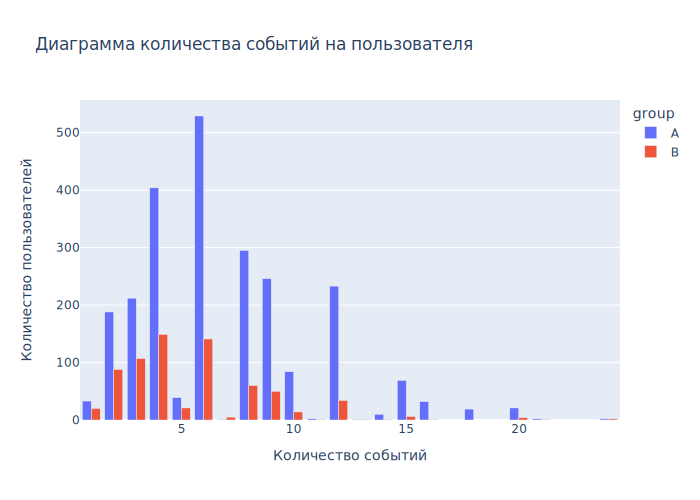

In [29]:
g = px.bar(events_count, x = 'event_name', y = 'user_id', color="group", barmode="group", 
           labels={'user_id':'Количество пользователей', 'event_name': 'Количество событий'},
          title="Диаграмма количества событий на пользователя")

g.show("png");


Показатель в 6 событий сильно выбивается вперед. В целом можно сказать, что в среднем пользователь совершает от 2 до 12 событий.

- Рассчитаем как число событий в выборках распределено по дням:

In [30]:
days = tables_mix.groupby(['event_dt', 'group'], as_index=False).agg({'event_name': 'count'})
days

,event_dt,group,event_name
0,2020-12-07,A,276
1,2020-12-07,B,290
2,2020-12-08,A,311
3,2020-12-08,B,183
4,2020-12-09,A,345
5,2020-12-09,B,273
6,2020-12-10,A,313
7,2020-12-10,B,196
8,2020-12-11,A,327
9,2020-12-11,B,122


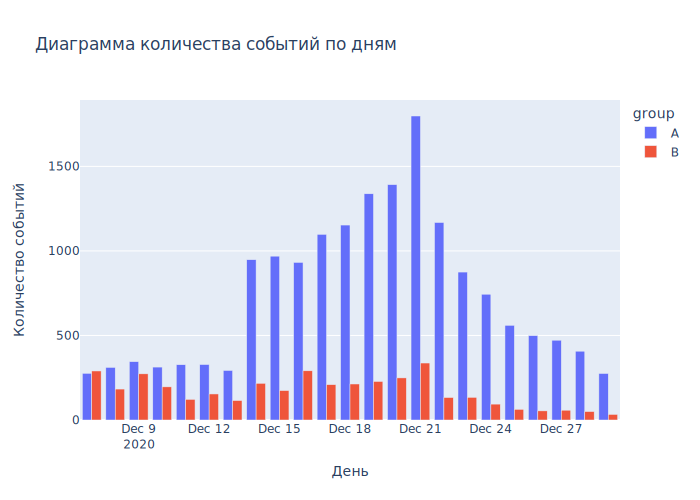

In [31]:
g = px.bar(days, x = 'event_dt', y = 'event_name', color="group", barmode="group", 
           labels={'event_dt':'День', 'event_name': 'Количество событий'},
          title="Диаграмма количества событий по дням")


g.show("png");

Видим скачок в количестве событий у группы А 14 декабря и 21 декабря, у группы В таких больших скачков не наблюдается. Данный всплеск может быть связан с предновогодней суматохой, в следствие чего был скачок и в количестве пользователей. Чтобы убедиться в этом, рассмотрим динамику набора пользователей.

In [32]:
first_days = tables_mix.groupby(['first_date', 'group'], as_index=False).agg({'user_id': 'count'})
first_days

,first_date,group,user_id
0,2020-12-07,A,845
1,2020-12-07,B,935
2,2020-12-08,A,568
3,2020-12-08,B,176
4,2020-12-09,A,475
5,2020-12-09,B,331
6,2020-12-10,A,295
7,2020-12-10,B,121
8,2020-12-11,A,469
9,2020-12-11,B,48


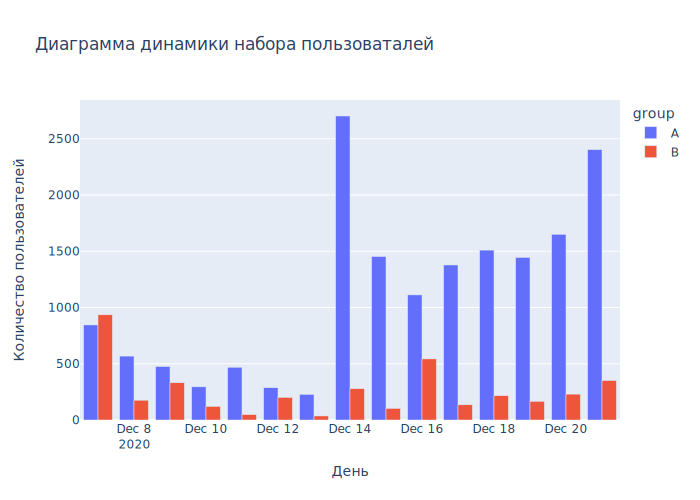

In [33]:
g = px.bar(first_days, x = 'first_date', y = 'user_id', color="group", barmode="group", 
           labels={'first_date':'День', 'user_id': 'Количество пользователей'},
          title="Диаграмма динамики набора пользоваталей")


g.show("png");

 По графику виден резкий скачок в количестве пользователей группы А 14 декабря, с этим же и связан аналогичный скачок в кол-ве событий. Динамика в бОльшем по отношению к датам 7- 13 декабря количестве новых пользователей сохраняется по 21 декабря, и 21 декабря тоже виден небольшой скачок, с чем и связан скачок в кол-ве событий.



- Рассмотрим изменение конверсии в воронке в выборках на разных этапах:

In [34]:
ev = pd.pivot_table(tables_mix, index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
ev = ev.reindex(['login', 'product_page', 'product_cart', 'purchase'])

ev

group,A,B
event_name,,
login,2422,705
product_page,1571,397
product_cart,728,195
purchase,773,198


In [35]:
ev['cov_A'] = round((ev['A']/ev['A'][0] * 100),1)
ev['cov_B'] = round((ev['B']/ev['B'][0] * 100),1)
ev

group,A,B,cov_A,cov_B
event_name,,,,
login,2422,705,100.0,100.0
product_page,1571,397,64.9,56.3
product_cart,728,195,30.1,27.7
purchase,773,198,31.9,28.1


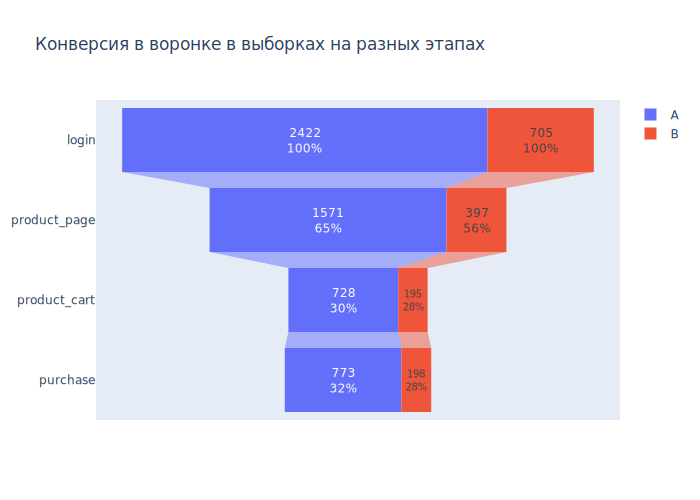

In [36]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'А',
    y = ["login", "product_page", "product_cart", "purchase"],
    x = ev['A'],
    textinfo = "value + percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ["login", "product_page", "product_cart", "purchase"],
    x = ev['B'],
    textposition = "inside",
    textinfo = "value + percent initial"))

fig.update_layout(title = 'Конверсия в воронке в выборках на разных этапах')

fig.show('png')

Группа В показала хуже результаты в конверсии, чем группа А. Конверсия в покупку у группы А составила 32%, у группы В в 28%. Так же можно заметить нюанс, что имеются пользователи, которые совершили платёж не заходя в корзину. Вероятнее всего, они купили только 1 товар. Это может говорить о том, что на платформе нестрогая воронка продаж и можно приобрести продукт минуя некоторые этапы.

- Итак, прежде чем приступать к А/В-тестированию акцентируем внимание на том, что данные не полностью соответствуют техническому заданию и в ходе проделанной выше работы мы получили следующие **выводы**:

1) Выборки А и Б не равны по количеству;

2) Максимальная дата в столбце с датой и временем события: 2020-12-30, хотя в тз планировалось 2021-01-04;

3) После "чистки" данных участников теста осталось 3128, хотя ожидалось 6000;

4) Время проведения теста совпало с приближением нового года, что тоже могло исказить результаты;

5) Были найдены и исключены из теста пользователи попавшие и в А и в В группы.

# 5. Оценка результатов A/B-тестирования

- Что можно сказать про результаты A/B-тестирования?

Результаты A/B-тестирования не можем считать корректными, тк имеются расхождения с пунктами тз (подробнее описано в абзаце выше). 

- Проверим статистическую разницу долей z-критерием

Посмотрим равна ли конверсия групп А и В с помошью z-теста для долей сравнив доли пользователей из каждой группы. 

За критический уровень статистической значимости при проверке гипотез примем alpha = .05, чтобы уменьшить вероятность получения ошибки второго рода.

1. Гипотеза о равенстве долей пользователей, совершивших покупку.

Н0: Доли пользователей, совершивших покупку, в обоих группах одинаковы.

Н1: Доли пользователей, совершивших покупку, в обоих группах разные.

In [37]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([ev['A'][3], ev['B'][3]])
trials = np.array([ev['A'][0], ev['B'][0]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

print(successes[0], successes[1], trials[0], trials[1])

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

773 198 2422 705


In [38]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

Если бы пропорции были равны, разница между ними была бы равна нулю. Посчитаем, как далеко статистика уехала от нуля. Какова вероятность получить такое отличие или больше?

In [39]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.05304232927356467
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: доли пользователей, совершивших покупку, в обоих группах одинаковы.

2. Гипотеза о равенстве долей пользователей, перешедших на окно просмотра корзины.

Н0: Доли пользователей, перешедших на окно просмотра корзины, в обоих группах одинаковы.

Н1: Доли пользователей, перешедших на окно просмотра корзины, в обоих группах разные.

In [40]:
successes = np.array([ev['A'][2], ev['B'][2]])
trials = np.array([ev['A'][0], ev['B'][0]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.21920158714376603
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**: доли пользователей, перешедших на окно просмотра корзины, в обоих группах одинаковы.

2. Гипотеза о равенстве долей пользователей, перешедших на окно просмотра карточки товара.

Н0: Доли пользователей, перешедших на окно просмотра карточки товара, в обоих группах одинаковы.

Н1: Доли пользователей, перешедших на окно просмотра карточки товара, в обоих группах разные.

In [41]:
successes = np.array([ev['A'][1], ev['B'][1]])
trials = np.array([ev['A'][0], ev['B'][0]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  3.5103235332289984e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод**: доли пользователей, перешедших на окно просмотра карточки товара, в обоих группах разные.

**Обший вывод по гипотезам:** хоть и доля пользователей, перешедших на окно просмотра карточки в группах А и В не равна, в общей картине, мы все равно не можем сказать что конверсия пользователей изменилась + по графику воронки видим, что группа В все равно показала хуже результат конверсии.

# Вывод

В результате исследования выявлены следующие пункты несоответствия с тз:
- Число активных (совершивших хотя бы одно событие) пользователей составило 3128, планировалось - 6000;
- Тест остановили на 5 дней раньше планируемой даты (планировалось 2021-01-04, по факту 2020-12-30);
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%, результаты исследования показали, что улучшение метрик не произошло.

А также,
- были выявлены и удалены пользователи, отнесенные одновременно к группе А и В;
- кол-во пользователей в группе В на треть меньше, чем пользователей группы А;
- тест совпал с приближающимся новым годом и проведением новогодней акции.

**Итог:** тест проведен неккорректно, рекомендуется провести его повторно, с соблюдением требований технического задания, с учетом отсутствия промо-акций и праздников и, конечно, с учетом чистоты сбора данных.
